In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
data = pd.read_csv('ESGData_cleaned2.csv', header=0)
data.head()

,Ticker,MSCI ESG Rating\n,ROA LF\n,ROE LF\n,Alpha:Y-1\n,P/E\n,Dvd Est Yld\n,Beta:Y-1\n,GICS Sector\n
0,AXP UN Equity,AA,4.243054,35.132084,0.132135,19.507507,1.060,0.983499,Financials
1,VZ UN Equity,A,6.460472,29.492355,-0.026806,9.940924,4.798,0.464678,Communication Services
2,PEP UW Equity,AA,8.222564,51.652710,0.067592,26.791130,2.694,0.609524,Consumer Staples
3,CAT UN Equity,A,8.055016,40.792080,-0.035480,17.117626,2.380,0.830970,Industrials
4,JPM UN Equity,A,1.355861,18.287388,-0.008087,9.839921,2.735,0.852132,Financials


In [23]:
data['GICS Sector\n'] = data['GICS Sector\n'].astype('category')
X = data.iloc[:, 2: ]
y = data['MSCI ESG Rating\n']

numeric_features = X.select_dtypes(include=['int', 'float']).columns    
categorical_features = X.select_dtypes(include=['object', 'category']).columns

scaler = StandardScaler()
X_scaled_numeric = pd.DataFrame(scaler.fit_transform(X[numeric_features]), columns=numeric_features, index=X.index)
X_scaled = pd.concat([X_scaled_numeric, X[categorical_features]], axis=1)
X_scaled = pd.get_dummies(X_scaled, columns=categorical_features, dtype='float64')

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

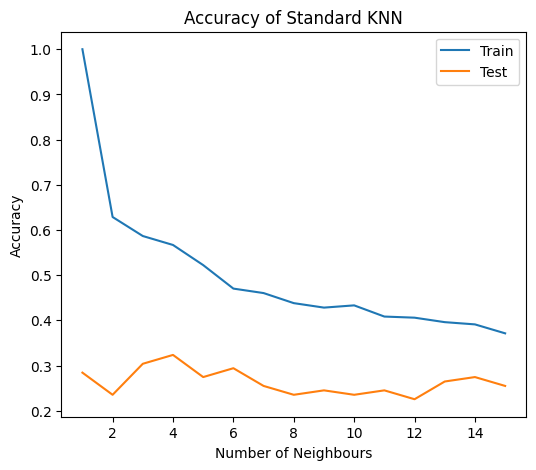

In [24]:
test_accuracy = []
train_accuracy = []
for i in range(1, 16):
    knn_classifier = KNeighborsClassifier(n_neighbors=i)
    knn_classifier.fit(X_train, y_train)
    train_prediction = knn_classifier.predict(np.array(X_train))
    train_accuracy.append(accuracy_score(y_train, train_prediction))
    test_predictions = knn_classifier.predict(np.array(X_test))
    test_accuracy.append(accuracy_score(y_test, test_predictions))

plt.figure(figsize=(6, 5))
plt.plot(range(1, 16), train_accuracy, label='Train')
plt.plot(range(1, 16), test_accuracy, label='Test')
plt.xlabel('Number of Neighbours')
plt.ylabel('Accuracy')
plt.title('Accuracy of Standard KNN')
plt.legend()
plt.show()

In [7]:
n = X.shape[0]

def entropy_subset(D):
    # D is a partition of the datatset given by array of non-overlapping indices
    
    counts = Counter(y[D])
    probabilities = np.array(list(counts.values())) / len(y[D])
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    return entropy

def entropy_partition(subsets):
    entropy = 0
    for D in subsets:
        entropy += len(D) * entropy_subset(D) / n
    
    return entropy

info = entropy_subset(range(n))

In [8]:
weights = []

In [9]:
# ROA

D1 = X[X['ROA LF\n'] <= 0].index
threshold = np.mean(X['ROA LF\n'][X[X['ROA LF\n'] > 0].index])
D2 = X[(0 < X['ROA LF\n']) & (X['ROA LF\n'] <= threshold)].index
D3 = X[X['ROA LF\n'] > threshold].index

info_roa = entropy_partition([D1, D2, D3])
weight_roa = np.sqrt(info - info_roa)
weights.append(weight_roa)

In [10]:
# ROE

D1 = X[X['ROE LF\n'] <= 0].index
threshold = np.mean(X['ROE LF\n'][X[X['ROE LF\n'] > 0].index])
D2 = X[(0 < X['ROE LF\n']) & (X['ROE LF\n'] <= threshold)].index
D3 = X[X['ROE LF\n'] > threshold].index

info_roe = entropy_partition([D1, D2, D3])
weight_roe = np.sqrt(info - info_roe)
weights.append(weight_roe)

In [11]:
# Alpha

D1 = X[X['Alpha:Y-1\n'] < 0].index
D2 = X[X['Alpha:Y-1\n'] >= 0].index

info_alpha = entropy_partition([D1, D2])
weight_alpha = np.sqrt(info - info_alpha)
weights.append(weight_alpha)

In [12]:
# DVD

D1 = X[X['Dvd Est Yld\n'] == 0].index
D2 = X[X['Dvd Est Yld\n'] != 0].index

info_dvd = entropy_partition([D1, D2])
weight_dvd = np.sqrt(info - info_dvd)
weights.append(weight_dvd)

In [13]:
# PE

D1 = X[(0 < X['P/E\n']) & (X['P/E\n'] <= 25)].index
D2 = X[(25 < X['P/E\n']) & (X['P/E\n'] <= 50)].index
D3 = X[50 < X['P/E\n']].index

info_pe = entropy_partition([D1, D2, D3])
weight_pe = np.sqrt(info - info_pe)
weights.append(weight_pe)

In [14]:
# Beta

D1 = X[X['Beta:Y-1\n'] < 1].index
D2 = X[X['Beta:Y-1\n'] >= 1].index

info_beta = entropy_partition([D1, D2])
weight_beta = np.sqrt(info - info_beta)
weights.append(weight_beta)

In [15]:
# Sector

D = []
for sector in X['GICS Sector\n'].unique():
    D.append(X[X['GICS Sector\n'] == sector].index)

info_sector = entropy_partition(D)
weight_sector = np.sqrt(info - info_sector)
weights.append(weight_sector)

In [17]:
print(pd.Series(weights / np.sum(weights), index=X.columns))

ROA LF\n         0.129423
ROE LF\n         0.156897
Alpha:Y-1\n      0.100705
P/E\n            0.091446
Dvd Est Yld\n    0.097872
Beta:Y-1\n       0.088038
GICS Sector\n    0.335620
dtype: float64


In [25]:
X_train[numeric_features] = weights[: -1] * X_train[numeric_features]
X_train.iloc[:, 6:] *= weight_sector
X_test[numeric_features] = weights[: -1] * X_test[numeric_features]
X_test.iloc[:, 6:] *= weight_sector

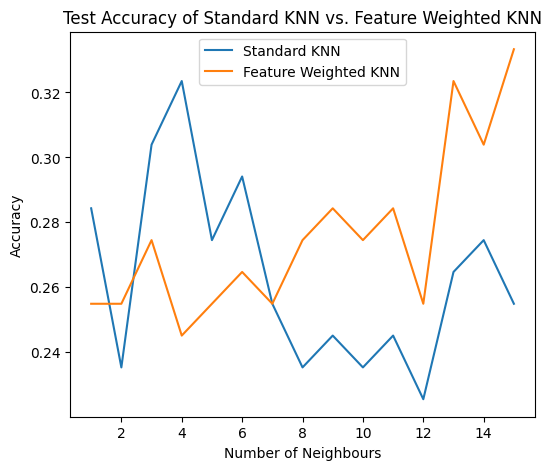

In [26]:
test_accuracy_weighted = []
for i in range(1, 16):
    knn_classifier = KNeighborsClassifier(n_neighbors=i)
    knn_classifier.fit(X_train, y_train)
    predictions = knn_classifier.predict(np.array(X_test))
    test_accuracy_weighted.append(accuracy_score(y_test, predictions))

plt.figure(figsize=(6, 5))
plt.plot(range(1, 16), test_accuracy, label='Standard KNN')
plt.plot(range(1, 16), test_accuracy_weighted, label='Feature Weighted KNN')
plt.xlabel('Number of Neighbours')
plt.ylabel('Accuracy')
plt.title('Test Accuracy of Standard KNN vs. Feature Weighted KNN')
plt.legend()
plt.show()